In [64]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt

mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"

conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

# smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df

def filter_smu_layers(smu_ids):
    # Filter to selected SMU_IDs
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(smu_ids)]

    return layers_filtered

smu_ids = extract_smu_ids(["Algeria", "Tunisia"])
smu_ids = (
    smu_ids.groupby("HWSD2_SMU_ID")[["lon", "lat"]]
    .mean()  # centroid per SMU
    .reset_index()
)

# print("SMU ID extraction complete.")

layers = filter_smu_layers(smu_ids["HWSD2_SMU_ID"])
# print("Layer filtering complete.")

layers = layers[layers["LAYER"] == "D1"]
useful_columns = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
layers = layers[useful_columns]

# print(layers.shape, smu_ids.shape)
# print("Column filtering complete.")

C:\Users\pc\AppData\Local\Temp\ipykernel_2304\667581337.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


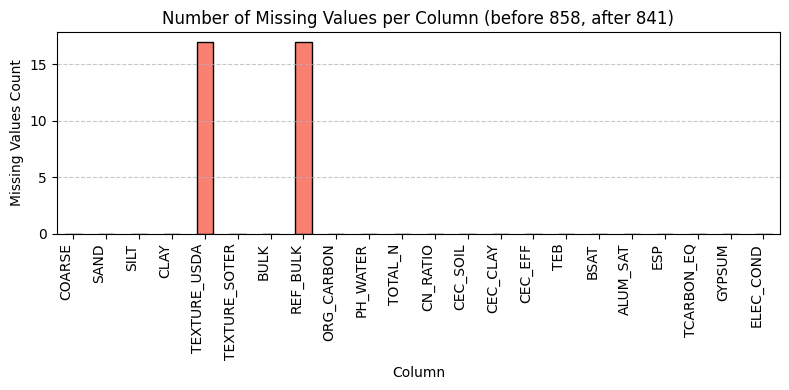

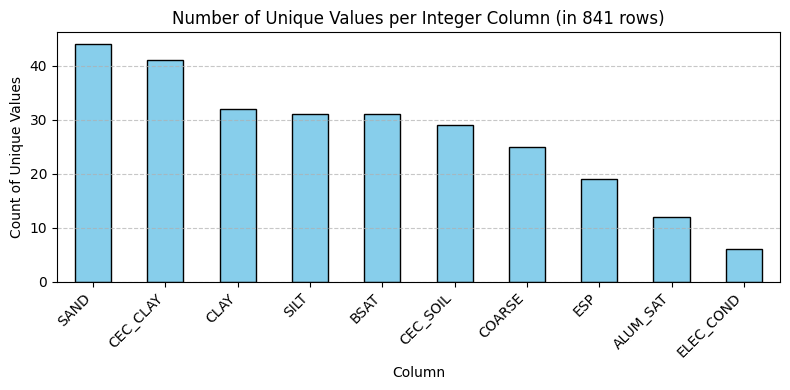

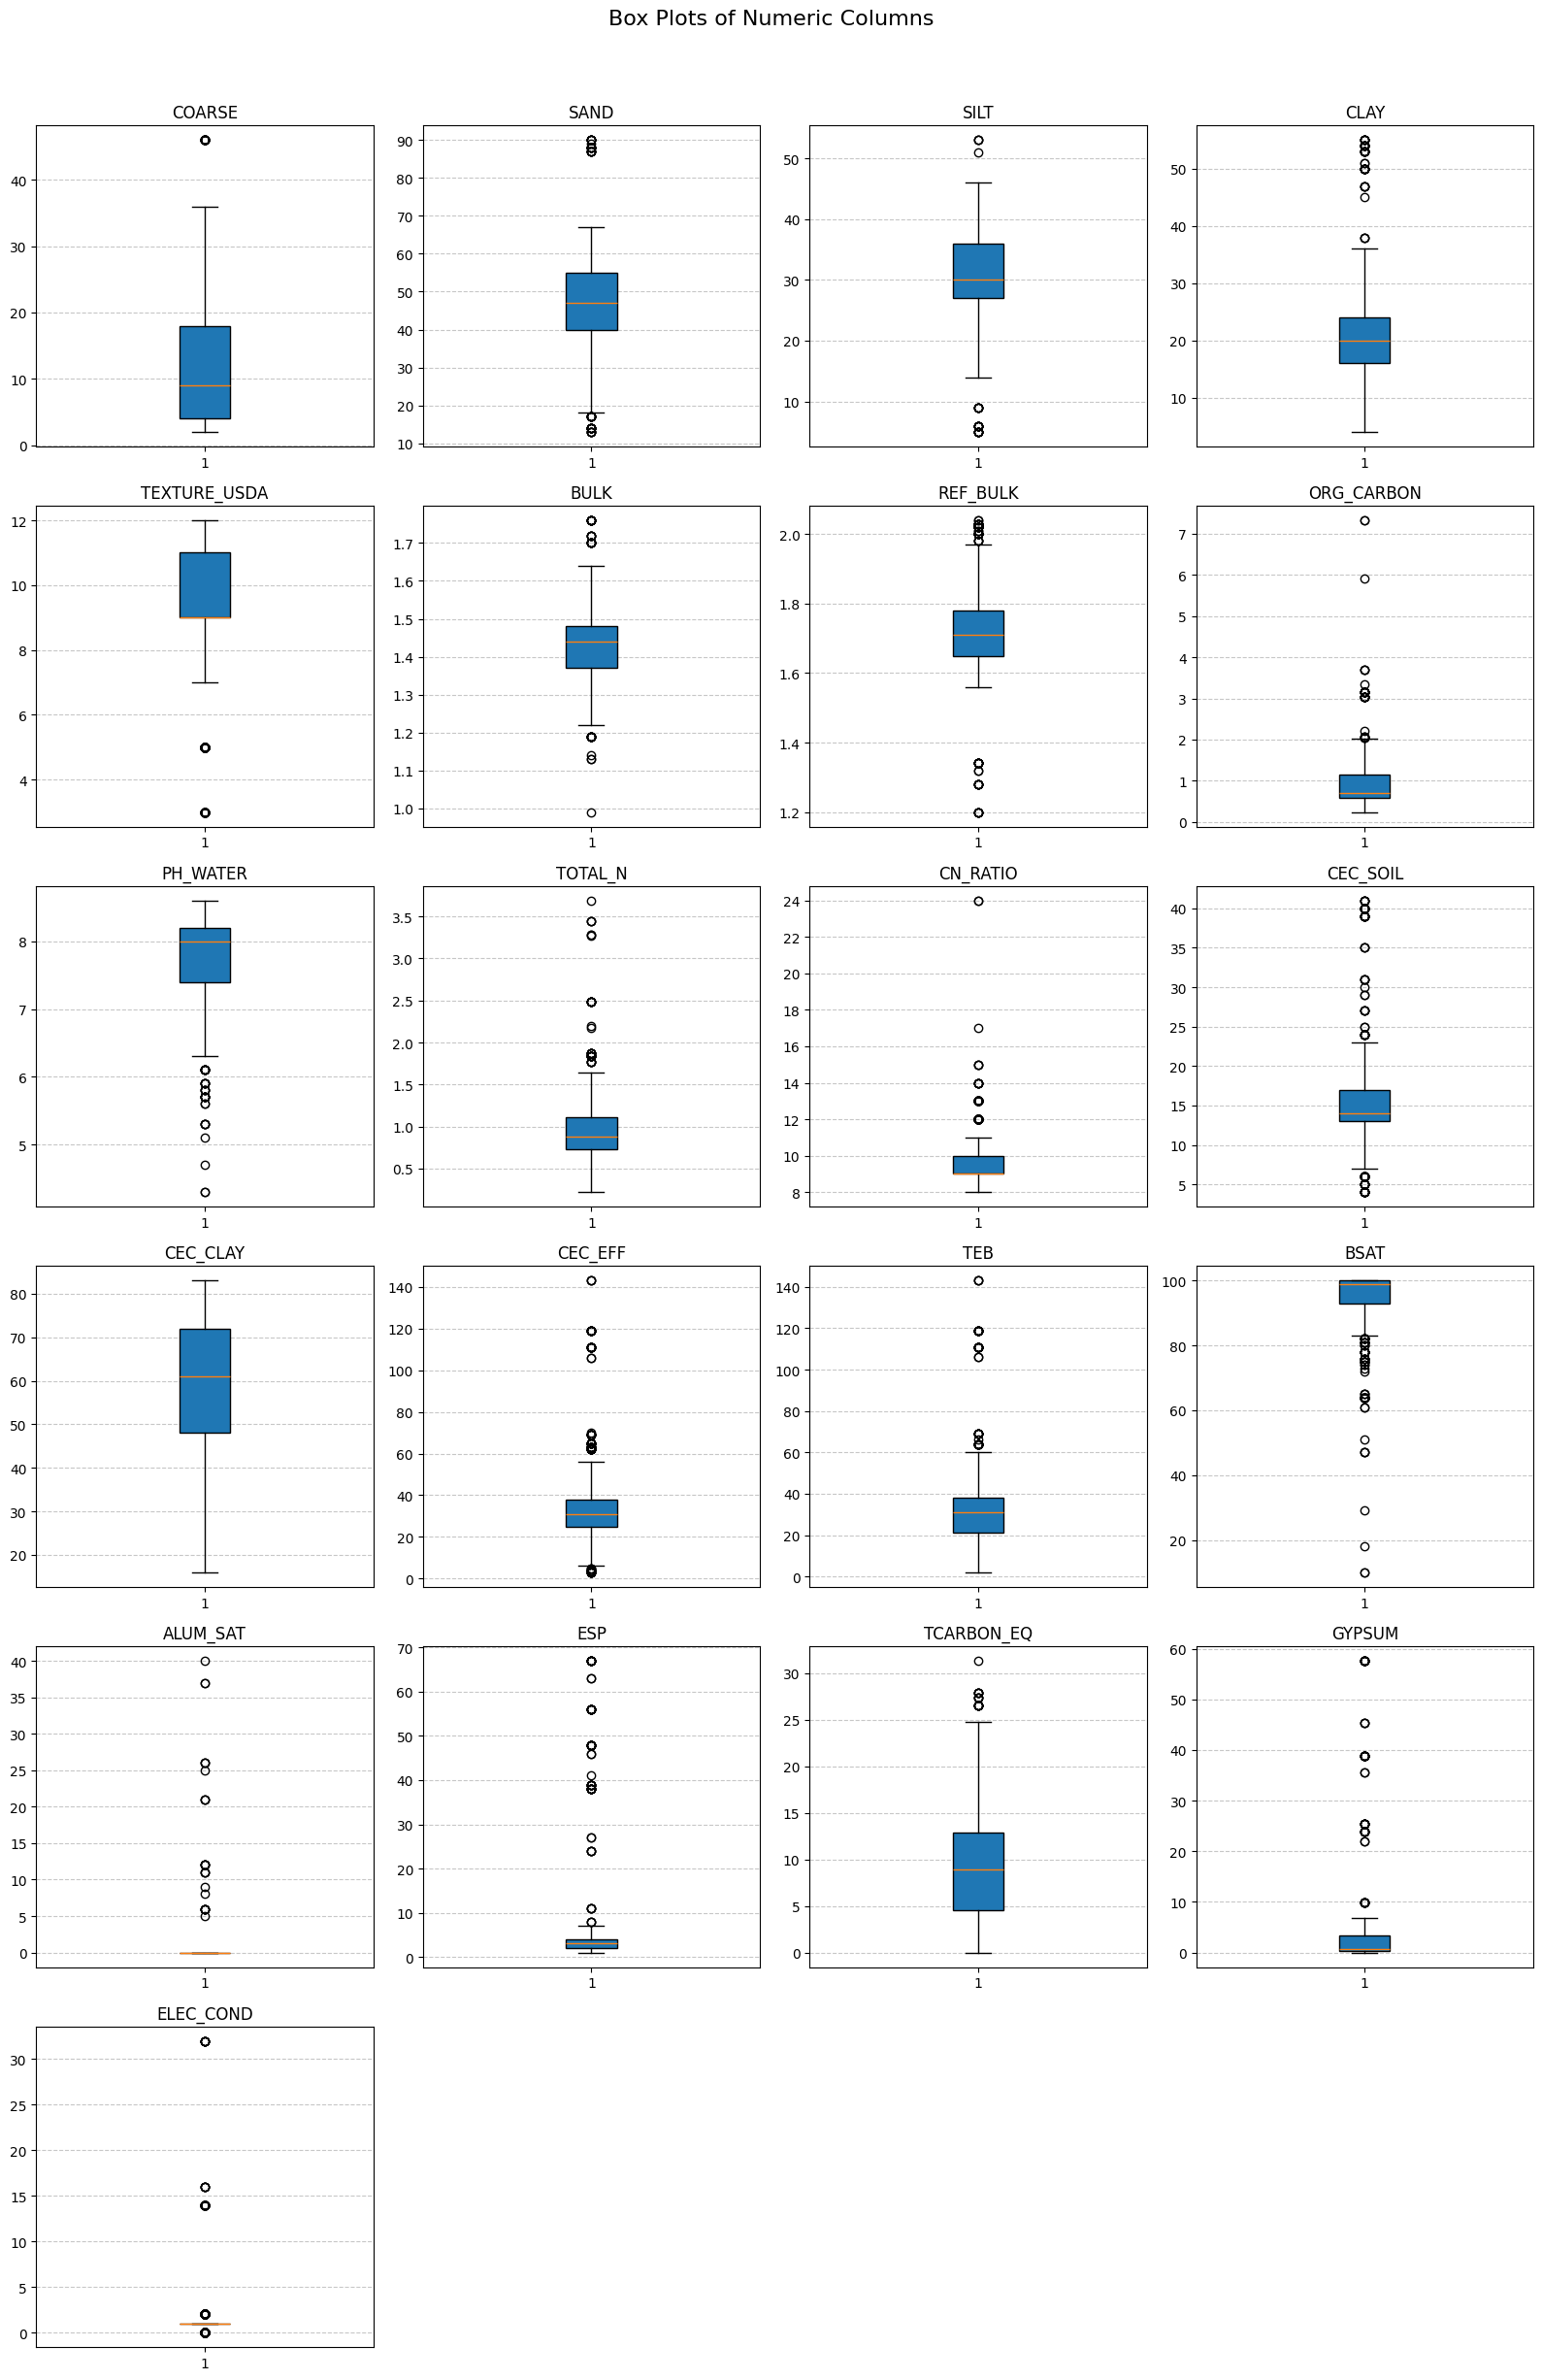

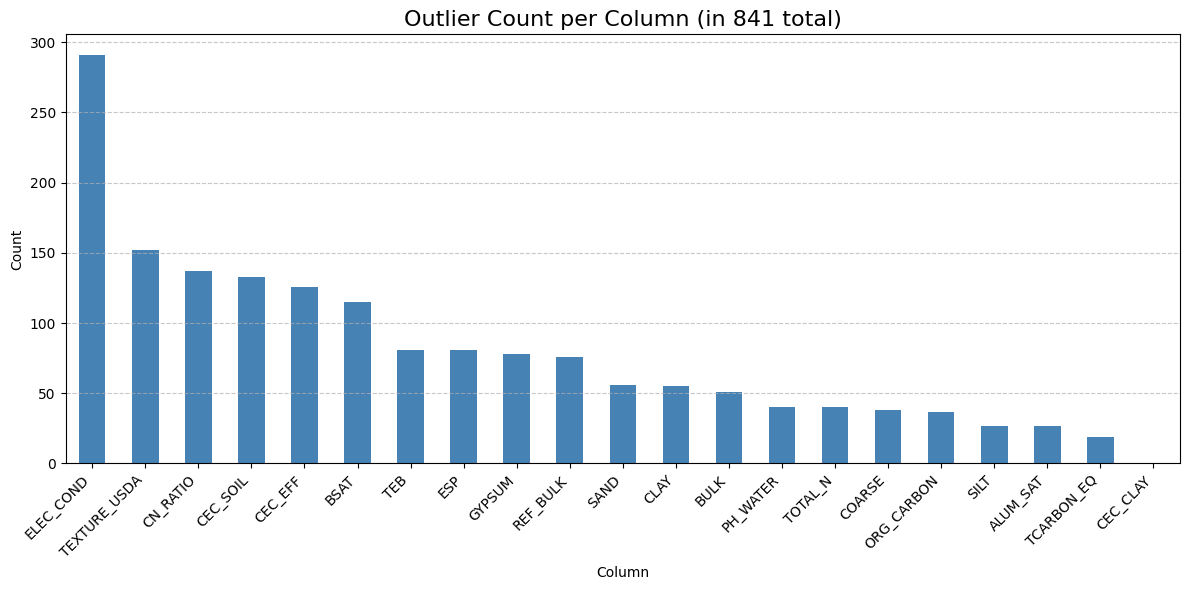

In [65]:


# ========================
# ======= ANALYSIS =======
# ========================


# print(layers.describe())

import math


# print(f"Shape {layers.shape}")
# print("=== Data types per column ===")
# print(layers.dtypes)

missing_values_percentage = layers.isnull().sum()
old_number_of_rows = layers.shape[0]
plt.figure(figsize=(8,4))
missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
layers = layers.dropna()
new_number_of_rows = layers.shape[0]

plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
plt.ylabel("Missing Values Count")
plt.xlabel("Column")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()






int_cols = layers.select_dtypes(include="int")
unique_counts = int_cols.nunique().sort_values(ascending=False)

plt.figure(figsize=(8,4))
unique_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title(f"Number of Unique Values per Integer Column (in {layers.shape[0]} rows)")
plt.ylabel("Count of Unique Values")
plt.xlabel("Column")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()






numeric_cols = layers.select_dtypes(include=["float", "int"])
n = len(numeric_cols.columns)
cols_per_row = 4  # you can change to 3 or 5 depending on your screen
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(cols_per_row * 4, rows * 4))
plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
for i, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(rows, cols_per_row, i)
    plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
    plt.title(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()







Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()







# =========================
# ======= EXPORTING =======
# =========================

# layers_full = layers.merge(smu_ids, on="HWSD2_SMU_ID", how="left")
# print("Merging complete.")



# layers_full.to_csv(r"dataset/soil_full.csv", index=False)
# print("CSV export complete.")

# xarray_layers_full = xarray.Dataset.from_dataframe(layers_full)
# xarray_layers_full.to_netcdf(r"dataset/soil_full.nc")
# print("NetCDF export complete.")

# nc_layers_full = xarray.open_dataset("dataset/soil/HWSD2_Full.nc")
# layers_full = nc_layers_full.to_dataframe().reset_index(drop=True)
# print(layers_full.head())
